In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# function to display progress

def print_progress(org_percentage):
    percentage = int(org_percentage / 2)
    if percentage < 1:
        print("\r[{}]".format(" " * 50), end="")
    elif 0 < percentage < 50:
        print("\r[{}] {}/100".format("=" * (percentage - 1) + ">" + " " * (50 - percentage), org_percentage), end="")
    else:
        print("\r[{}] 100/100".format("=" * 50))

# A

## Lösungsansatz
Um festzustellen welches Bild zu welchem Modell gehört, schauen wir uns an wie gut die beiden Modelle im Vergleich bei
jedem einzelnem Bild performen, denn wenn eins der Modelle das Bild zum trainieren verwendet hat ist es wahrscheinlich,
dass es das Bild richtig mit einer höheren Confidence vorhersagt als das andere.

Um einen Vergleichswert zu haben laden wir das MNIST Datenset und suchen die original Labels.

## Bilder, Modelle und MNIST Set laden

In [3]:
images = np.load("samples.npy")

model_one = keras.models.load_model("model1.hdf5")
model_two = keras.models.load_model("model2.hdf5")

# train/test ist egal
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test])
Y = np.concatenate([Y_train, Y_test])

## Original Labels aus dem MNIST Datenset extrahieren
Zuerst formatieren wir die Bilder aus der Datei etwas, damit wir sie mit den Bildern aus dem MNIST Datenset vergleichen
können:
* entfernen der letzten Dimension
* mit 255 multiplizieren und zu `int` konvertieren

Danach vergleichen wir den Array aus Pixeln mit jedem Bild aus dem MNIST-Datenset.

In [4]:
images_flat = (images[:, :, :, 0] * 255).astype(int)

data = []

print("Labeling Images...")
progress = 0

for image in images_flat:
    print_progress(progress)
    found = False
    idx = 0
    for x in X:
        if np.array_equal(image, x):
            found = True
            data.append({
                "label": Y[idx],
                "image": image
            })
            continue
        idx += 1
    if not found:
        raise ValueError("Could not determine Label of Image")
    progress += 1

print_progress(progress)
print("Done!")

for i in range(len(data)):
    data[i]["id"] = i

Labeling Images...
[==================================================] 100/100
Done!


## Beide Modelle alle Bilder vorhersagen lassen

In [5]:
res_model_one = model_one.predict(images)
res_model_two = model_two.predict(images)

## Validierung der Vorhersagen
Um eine erste Einteilung vorzunehmen, wenden wir folgende Regeln an:
* Wenn nur eines von beiden Modellen die Zahl richtig vorhergesagt markieren wir das Bild mit `key=1/2` (und
`model=1/2)`für das jeweilige Modell und speichern den Score des Modells
* Wenn beide das Bild richtig vorhergesagt haben wird das Bild mit `key=b` für both gekennzeichnet und die scores werden
gespeichert
  * Zusätzlich wird das bild mit `model=1/2` markiert, je nach dem welches Bild den besseren Score hat
  * Falls beide gleich gut sind wird das Bild mit `model=e` für equal markiert
* Wenn beide Modelle eine falsche Vorhersage gemacht haben wird das Bild mit `key=n` für none markiert
* Zusätzlich speichern wir das Modell das bei einem Bild am besten war in `result` allerdings werden wir dieses Feld
später noch modifizieren um auf genau 50/50 zu kommen

In [6]:
"""
Data-Structure:
{
    key:       indicates which model got it right (b: both, n: none, 1, 2)
    model:     indicates which model performed best (e: equal, 1, 2)
    label:     contains the label extracted from the MNIST dataset
    image:     contains the image data
    model_one: score for model one -> None if the prediction was wrong
    model_two: score for model two -> None if the prediction was wrong
    result:    contains the final result -> will be modified later on
}
"""

for idx in range(len(images)):
    # Ergebnisse der Größe nach aufsteigend sortieren und den letzten Index nehmen 
    one_val_idx = np.argsort(res_model_one[idx])[len(res_model_one[idx]) - 1]
    two_val_idx = np.argsort(res_model_two[idx])[len(res_model_two[idx]) - 1]
    data_point = {
        "key": "n",
        "model": None,
        "model_one": None,
        "model_two": None,
    }
    if one_val_idx != data[idx]["label"] and two_val_idx != data[idx]["label"]:
        data_point["key"] = "n"
    elif one_val_idx == data[idx]["label"] != two_val_idx:
        data_point["key"] = 1
        data_point["result"] = 1
        data_point["model"] = 1
        data_point["model_one"] = res_model_one[idx][one_val_idx]
    elif two_val_idx == data[idx]["label"] != one_val_idx:
        data_point["key"] = 2
        data_point["result"] = 2
        data_point["model"] = 2
        data_point["model_two"] = res_model_two[idx][two_val_idx]
    elif res_model_one[idx][one_val_idx] == res_model_two[idx][two_val_idx]:
        data_point["key"] = "b"
        data_point["model"] = "e"
        data_point["model_one"] = res_model_one[idx][one_val_idx]
        data_point["model_two"] = res_model_two[idx][two_val_idx]
    else:
        data_point["key"] = "b"
        data_point["model"] = 1 if res_model_one[idx][one_val_idx] > res_model_two[idx][two_val_idx] else 2
        data_point["result"] = 1 if res_model_one[idx][one_val_idx] > res_model_two[idx][two_val_idx] else 2
        data_point["model_one"] = res_model_one[idx][one_val_idx]
        data_point["model_two"] = res_model_two[idx][two_val_idx]
    data[idx] = {**data[idx], **data_point}

### Ergebnis der Vorhersage

In [7]:
one = 0
two = 0
non = 0
bth = 0

for el in data:
    if el["key"] == 1:
        one += 1
    elif el["key"] == 2:
        two += 1
    elif el["key"] == "n":
        non += 1
    elif el["key"] == "b":
        bth += 1
    else:
        raise ValueError("Unkown key {}".format(el["key"]))

print("None: {}\nOne: {}\nTwo: {}\nBoth: {}".format(non, one, two, bth))

None: 0
One: 7
Two: 8
Both: 85


Aufteilung auf Modell eins und zwei:

In [8]:
one = 0
two = 0
equ = 0

for el in data:
    if el["key"] == 1:
        one += 1
    elif el["key"] == 2:
        two += 1
    elif el["key"] == "b":
        if el["model"] == 1:
            one += 1
        elif el["model"] == 2:
            two += 1
        elif el["model"] == "e":
            equ += 1
        else:
            raise ValueError("Error")
    else:
        raise ValueError("Error")

print("One: {}\nTwo: {}\nEqual: {}".format(one, two, equ))

One: 32
Two: 68
Equal: 0


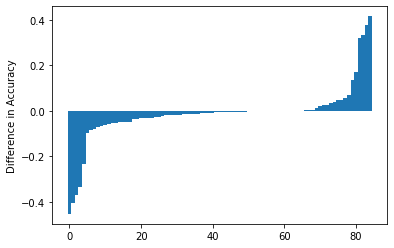

In [9]:
plot_data = [el["model_one"] - el["model_two"] for el in data if el["key"] == "b" and el["model"] != "e"]
plot_data.sort()
plt.bar(range(len(plot_data)), plot_data, width=1)
plt.ylabel("Difference in Accuracy")
plt.show()

## Auswertung 
Wie wir sehen können haben wir keine Bilder die von keinem Modell richtig vorhergesagt wurden und auch keine Bilder bei
denen beide Modelle gleich gut performed haben. Einige Bilder wurden nur von jeweils einem Modell richtig vorhergesagt,
diese Bilder ordnen wir direkt dem entsprechenden Modell zu.   
Bei den restlichen Bildern ordnen wir das Bild dem Modell zu, dass das richtige Bild mit höherer Confidence
vorhergesagt hat. 
Dadurch hat Modell 2 wesentlich mehr Bilder zugewiesen bekommen als Modell 1.  
In dem Graphen kann man gut erkennen, dass es einige wenige Bilder gibt bei denen wir eine klare zuordnung
machen können da die Differenz in der Confidence größer als 0.1 ist.

Um die Aufteilung 50/50 zu erhalten, schauen wir jetzt welche Bilder von Modell eins zu Modell zwei umschichten können.

Kriterien:
1. Beide Modelle müssen das Bild richtig vorhergesagt haben
*  Modell 2 muss das Bild mit einer höheren Confidence vorhergesagt haben als Modell 1
*  Modell 1 muss das Bild mit möglichst viel Confidence vorhergesagt haben
*  Modell 2 muss das Bild mit möglichst wenig Confidence vorhergesagt haben

Um die optimalen Bilder zu finden, bilden wir für jedes Bild, das Kriterien 1 & 2 erfüllt, einen Score aus Kriterien
3 & 4:  
`Score = 1 - Model Two Confidence + Model One Confidence`  
_Je niedriger die Confidence von Modell 2 desto höher der Score und je höher die Confidence von Modell 1 desto höher der
Score (und jeweils umgekehrt)._  
Danach wählen wir die 18 Bilder mit dem höchsten Score aus und ordnen sie dem ersten Modell zu.

In [10]:
for (i, el) in enumerate(data):
    if el["key"] != "b" or (el["key"] == "b" and el["model_one"] > el["model_two"]):
        continue
    data[i]["score"] = 1 - el["model_two"] + el["model_one"]

data.sort(key=lambda el: el["score"] if "score" in el.keys() else 0, reverse=True)

for i in range(18):
    data[i]["result"] = 1

# um die reihenfolge für das korrekte ergebnis zu bekommen sortieren wir die Liste wieder zurück
data.sort(key=lambda el: el["id"])

## Ergebnis

In [11]:
print([el["result"] for el in data])

[2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2]


# B

## Aufteilung der Labels auf die beiden Modelle vergleichen

### Welches Modell hat von welchen Labels wie viele richtig/falsch vorhergesagt?

In [12]:
# zählen wieviele jedes modell von jedem modell richtig und falsch hatte
model_one_labels_right = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_one_labels_wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_two_labels_right = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_two_labels_wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for el in data:
    if el["key"] == "b":
        model_one_labels_right[el["label"]] += 1
        model_two_labels_right[el["label"]] += 1
    elif el["key"] == 1:
        model_one_labels_right[el["label"]] += 1
        model_two_labels_wrong[el["label"]] -= 1
    elif el["key"] == 2:
        model_two_labels_right[el["label"]] += 1
        model_one_labels_wrong[el["label"]] -= 1

# labels aus dem datenset lesen
(labels, l_counts) = np.unique([el["label"] for el in data], return_counts=True)

# und in einheitliche Liste übertragen damit eventuell fehlende labels auf 0 gesetzt werden
label_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# for (label, count) in labels:
    # label_counts[label] = count

for idx in range(len(labels)):
    label_counts[labels[idx]] = l_counts[idx]

# die gezählten werte in prozentzahlen umrechnen
for idx in range(10):
    if label_counts[idx] == 0:
        continue
    model_one_labels_right[idx] = model_one_labels_right[idx] / label_counts[idx]
    model_one_labels_wrong[idx] = model_one_labels_wrong[idx] / label_counts[idx]
    model_two_labels_right[idx] = model_two_labels_right[idx] / label_counts[idx]
    model_two_labels_wrong[idx] = model_two_labels_wrong[idx] / label_counts[idx]

bar_labels = range(10)

### Für Model Eins

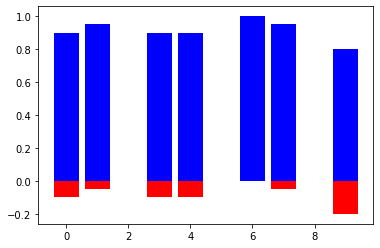

In [13]:
fig = plt.figure()
ax = plt.subplot()
ax.bar(bar_labels, model_one_labels_wrong, width=0.8, color='r')
ax.bar(bar_labels, model_one_labels_right, width=0.8, color='b')

plt.show()

### Für Modell 2

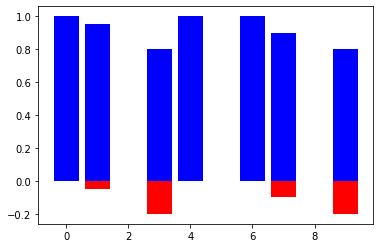

In [14]:
fig = plt.figure()
ax = plt.subplot()
ax.bar(bar_labels, model_two_labels_wrong, width=0.8, color='r')
ax.bar(bar_labels, model_two_labels_right, width=0.8, color='b')

plt.show()

## Wie hoch ist die Confidence des Modells bei den verschiedenen Ziffern?

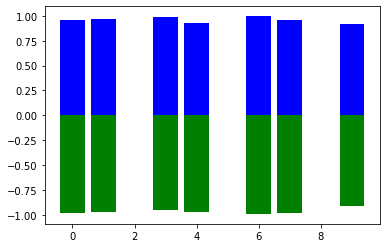

In [15]:
model_one_sum_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_one_avg_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_one_count_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

model_two_sum_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_two_avg_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
model_two_count_confidence = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for el in data:
    if el["key"] == "b":
        model_one_sum_confidence[el["label"]] += el["model_one"]
        model_one_count_confidence[el["label"]] += 1
        model_two_sum_confidence[el["label"]] += el["model_two"]
        model_two_count_confidence[el["label"]] += 1
    elif el["key"] == 1:
        model_one_sum_confidence[el["label"]] += el["model_one"]
        model_one_count_confidence[el["label"]] += 1
    elif el["key"] == 2:
        model_two_sum_confidence[el["label"]] += el["model_two"]
        model_two_count_confidence[el["label"]] += 1

for idx in range(10):
    model_one_avg_confidence[idx] = model_one_sum_confidence[idx] / model_one_count_confidence[idx] if model_one_count_confidence[idx] != 0 else 0
    model_two_avg_confidence[idx] = model_two_sum_confidence[idx] / model_two_count_confidence[idx] * (-1) if model_two_count_confidence[idx] != 0 else 0

fig = plt.figure()
ax = plt.subplot()
ax.bar(bar_labels, model_two_avg_confidence, width=0.8, color='g')
ax.bar(bar_labels, model_one_avg_confidence, width=0.8, color='b')

plt.show()

## Auswertung
Wie man sehen kann, sind beide Modelle nahezu gleich gut auf den selben Bildern, vermutlich wurden beide Modelle auf
ähnlich balancierten Datensets trainiert. Es gibt keine extremen Ausfälle (nicht sehr viel falsche Vorhersagen).

Modell 1 hat eine sehr ausgeglichene Verteilung, es erkennt fast alle Zahlen größtenteils richtig mit Ausnahme der
Zahl 9.

Modell 2 hat bei 1, 4 und 6 keine Fehler, vermutlich hatte das Modell im Trainingsset mehr von diesen Bildern.
Besonders bei der drei treten vermehrt Fehler aus, vermutlich waren wenige dreier im Modell enthalten.

# C

### A
Um die samples aus der der Datei mit den richtigen Labels zu versehen habe ich zuerst probiert die Bilder einzeln
anzuschauen und so zuzuordnen, allerdings ist das ungenau und auch nur bedingt begründbar.

Die Datensets auszugleichen ist auch nicht einfach gewesen, eine Art Score zu bilden war dann die logischste Lösung.

### B
Es ist schwierig genaue Einblicke in die Daten zu erhalten wenn die einzige Grundlage eine grobe Einteilung ist die man
selbst gemacht hat. Durch das anschauen verschiedener Auswertungen habe ich dann ein halbwegs klares Bild erhalten.